# Imports and Data Preparation

Comparisions for RF-GAP
    - MALI
    - KEMA (MAT-LAB); wait


Some Ideas:
- Since this method requires labels, we could classiy different domains based on the labels. For example, if we have a data set of people sick with Creutzfeld-Jakob discease and the other domain is people who are sick with alzheimers. 

In [1]:
from mashspud import MASH
import numpy as np
import pandas as pd
import Main.test_manifold_algorithms as tma
from mashspud import SPUD
from Helpers.rfgap import RFGAP
import matplotlib.pyplot as plt
from Helpers.Pipeline_Helpers import rf_test_proximities

#DC is short for data class
dc = tma.test_manifold_algorithms(csv_file="seeds.csv", split = "skewed", percent_of_anchors= [0.2], verbose = 4, random_state= 42)

2024-12-30 09:04:58.575155: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-30 09:04:58.616916: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-30 09:04:58.629739: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-30 09:04:58.656590: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-30 09:05:00.953039: W tensorflow/comp

MDS initialized with 3 components

 
 
---------------------------       Initalizing class with seeds.csv data       ---------------------------

The knn values are: (2, 6, 10, 14, 18, 22, 26, 30, 34, 38)


In [2]:
def use_rf_proximities(self, tuple):
    """Creates RF proximities similarities
    
        tuple should be a tuple with position 0 being the data and position 1 being the labels"""
    #Initilize Class
    rf_class = RFGAP(prediction_type="classification", y=tuple[1], prox_method="rfgap", matrix_type= "dense", triangular=False, non_zero_diagonal=True)

    #Fit it for Data A
    rf_class.fit(tuple[0], y = tuple[1])

    #Get promities
    dataA = rf_class.get_proximities()

    #Reset len_A and other varables
    if self.len_A == 2:
        self.len_A = len(tuple[0]) 

        #Change known_anchors to correspond to off diagonal matricies -- We have to change this as its dependent upon A
        self.known_anchors_adjusted = np.vstack([self.known_anchors.T[0], self.known_anchors.T[1] + self.len_A]).T

    elif self.len_B == 2:
        self.len_B = len(tuple[0])

    #Scale it and check to ensure no devision by 0
    if np.max(dataA[~np.isinf(dataA)]) != 0:

      dataA = (dataA - dataA.min()) / (dataA[~np.isinf(dataA)].max() - dataA.min()) 

    #Reset inf values
    dataA[np.isinf(dataA)] = 0

    return 1 - dataA

# Applying RF GAP for SPUD

In [4]:
#Initialize SPUD Class
spud_class = SPUD(distance_measure_A = use_rf_proximities, distance_measure_B= use_rf_proximities, knn = 3, verbose = 4)

#Fit SPUD
spud_class.fit(dataA = (dc.split_A, dc.labels), dataB = (dc.split_B, dc.labels), known_anchors = dc.anchors[:3])

Time it took to compute SGDM:  0.48
Time it took to execute graphtools.Graph functions:  0.38
Time it took to execute merge_graphs function:  0.0
Time it took to execute get_block function:  0.01
<><><><><><><><><><><><><>  Processed Finished  <><><><><><><><><><><><><>


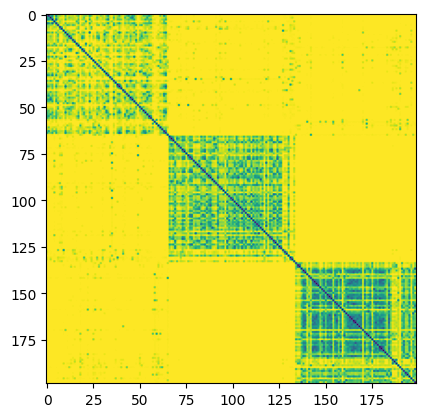

In [5]:
plt.imshow(spud_class.block[:spud_class.len_A, :spud_class.len_A])


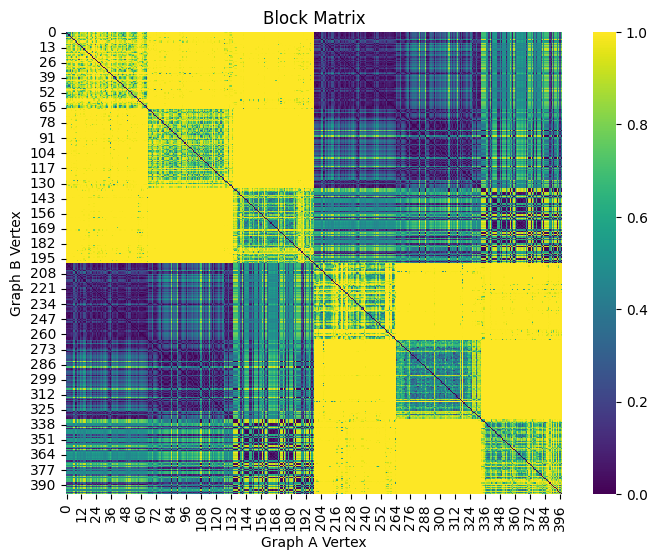

In [6]:
spud_class.plot_heat_map()

Time it took to calculate the embedding: 2.51
Calculating the classification Score.
RF-GAP score is accuracy
RF score on full embedding: 0.9170854271356784
Cross Embedding score: 0.9221105527638191
Fraction of Samples Closest to thier Match: 0.007499810610843162


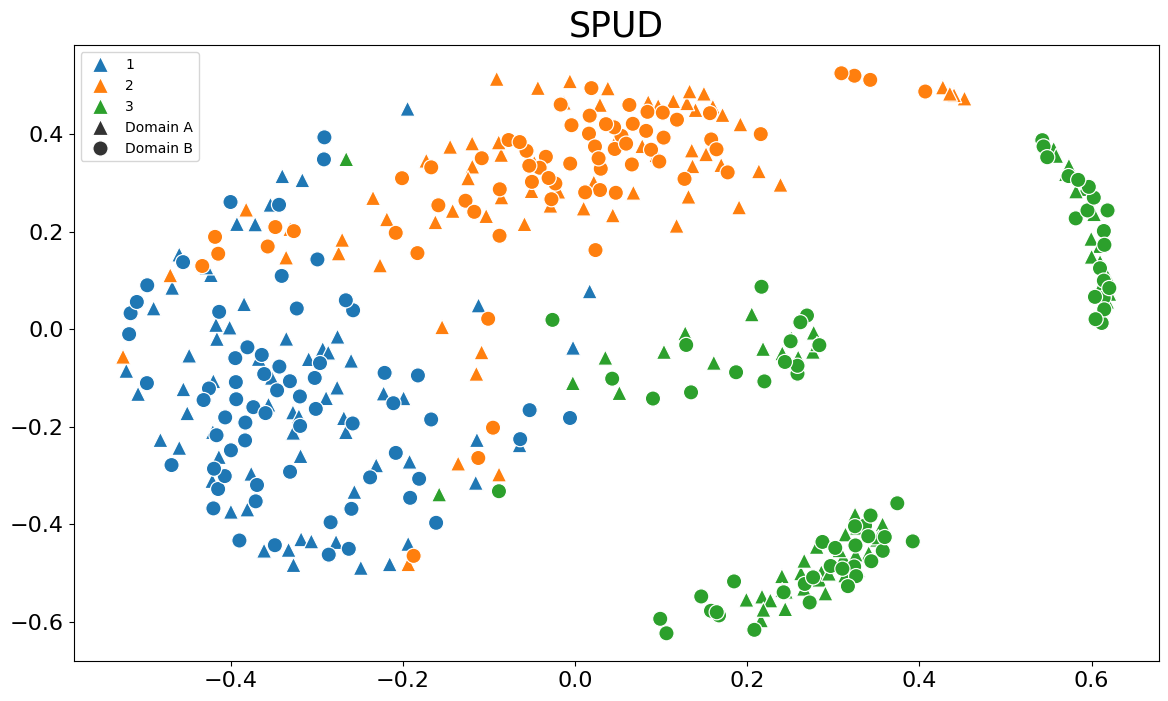

Time it took complete the plots: 0.29


In [7]:
spud_class.plot_emb(labels = dc.labels_doubled, show_anchors = False, show_lines = False)

# Applying RF GAP for MASH

In [3]:
#Initialize SPUD Class
mash_class = MASH(distance_measure_A = use_rf_proximities, distance_measure_B= use_rf_proximities, knn = 4, verbose = 0, DTM = "hellinger")

#Fit SPUD
mash_class.fit(dataA = (dc.split_A, dc.labels), dataB = (dc.split_B, dc.labels), known_anchors = dc.anchors[12:15])

Cross Embedding score: 0.6633165829145728
Fraction of Samples Closest to thier Match: 0.330370445190778
RF score trained on full Embedding: 0.9346733668341709


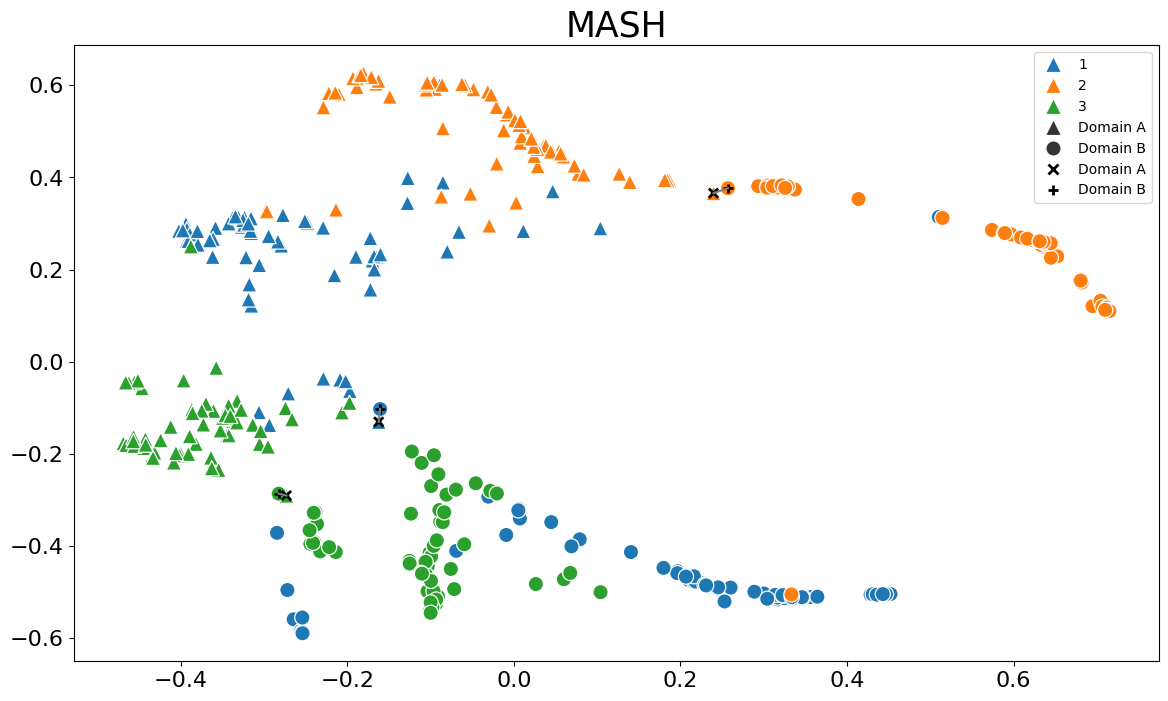

In [4]:
mash_class.plot_emb(labels = dc.labels_doubled, show_anchors = True, show_lines = False)

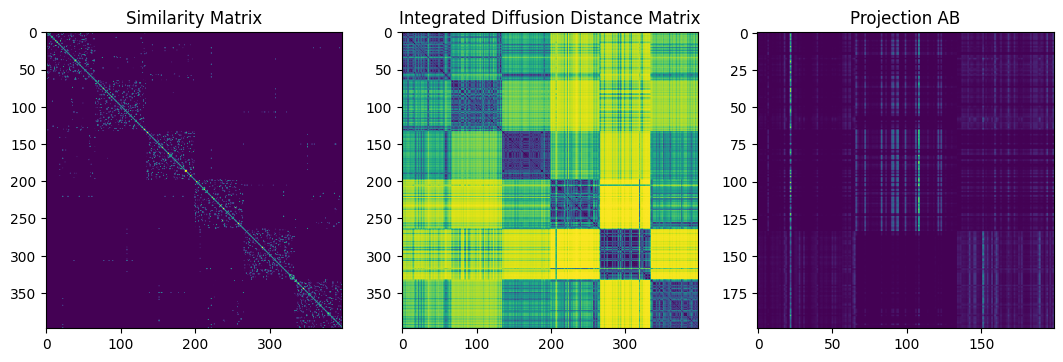

In [5]:
mash_class.plot_heat_maps()

Time Data Below
 Time it took to execute the graph for domain A:  0.08925
 Time it took to compute kernal A:  0.00011
 Time it took to execute the graph for domain B:  0.07202
 Time it took to compute kernal B:  0.00011


 Time it took to compute merge_graphs function:  0.0764
 Time it took to compute similarity_matrix function:  0.00075
Using optimal t value of 24
 Time it took to compute diffusion process:  0.11135
Fit process finished. We recommend calling optimize_by_creating_connections.


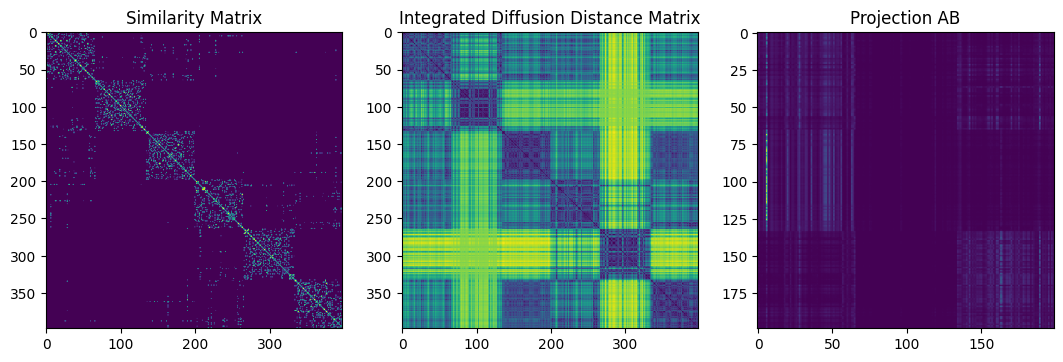

In [6]:
#Initialize SPUD Class
mash_class2 = MASH(knn = 8, verbose = 3, DTM = "log")
mash_class2.fit(dataA = dc.split_A, dataB = dc.split_B, known_anchors = dc.anchors[:4])
mash_class2.plot_heat_maps()

Time it took to calculate the embedding: 0.80373
RF-GAP score is accuracy
Calculating the classification Score.
Cross Embedding score: 0.5904522613065326
Fraction of Samples Closest to thier Match: 0.21916113229463902
RF score trained on full Embedding: 0.9246231155778895


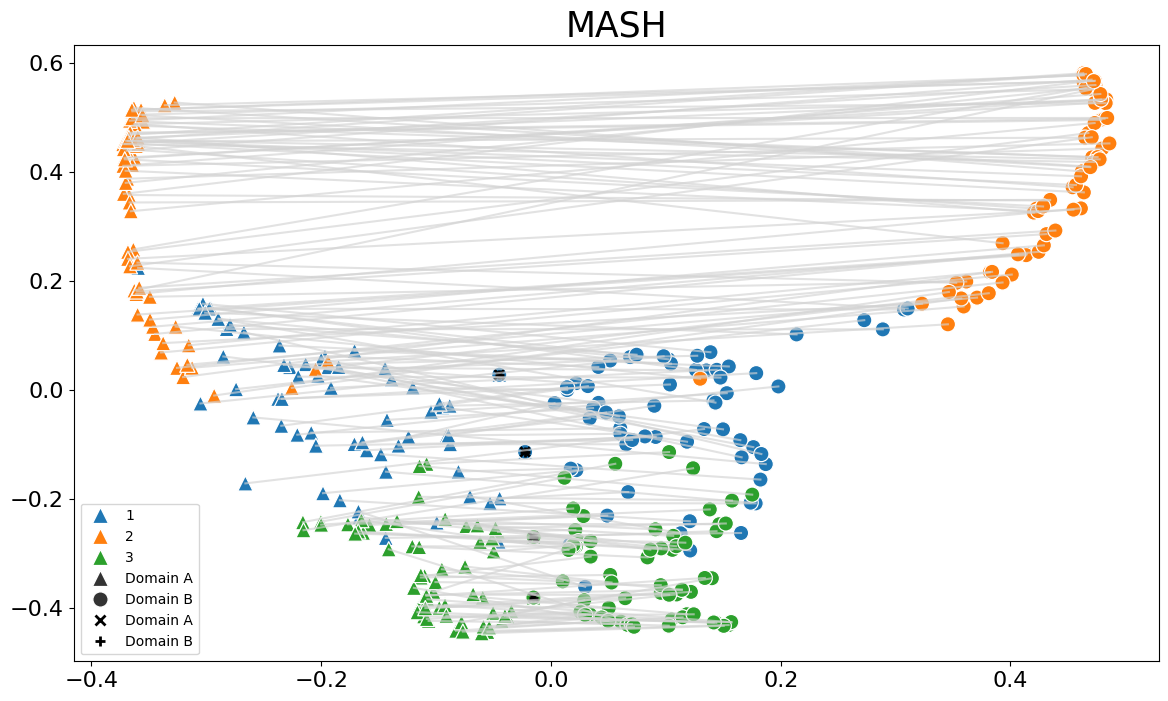

In [7]:
mash_class2.plot_emb(labels = dc.labels_doubled)

In [8]:
mash_class.optimize_by_creating_connections(epochs=3, connection_limit= 30, threshold = 0.9, hold_out_anchors=dc.anchors[4:8])

True

Cross Embedding score: 0.6633165829145728
Fraction of Samples Closest to thier Match: 0.28004343324663517
RF score trained on full Embedding: 0.9271356783919598


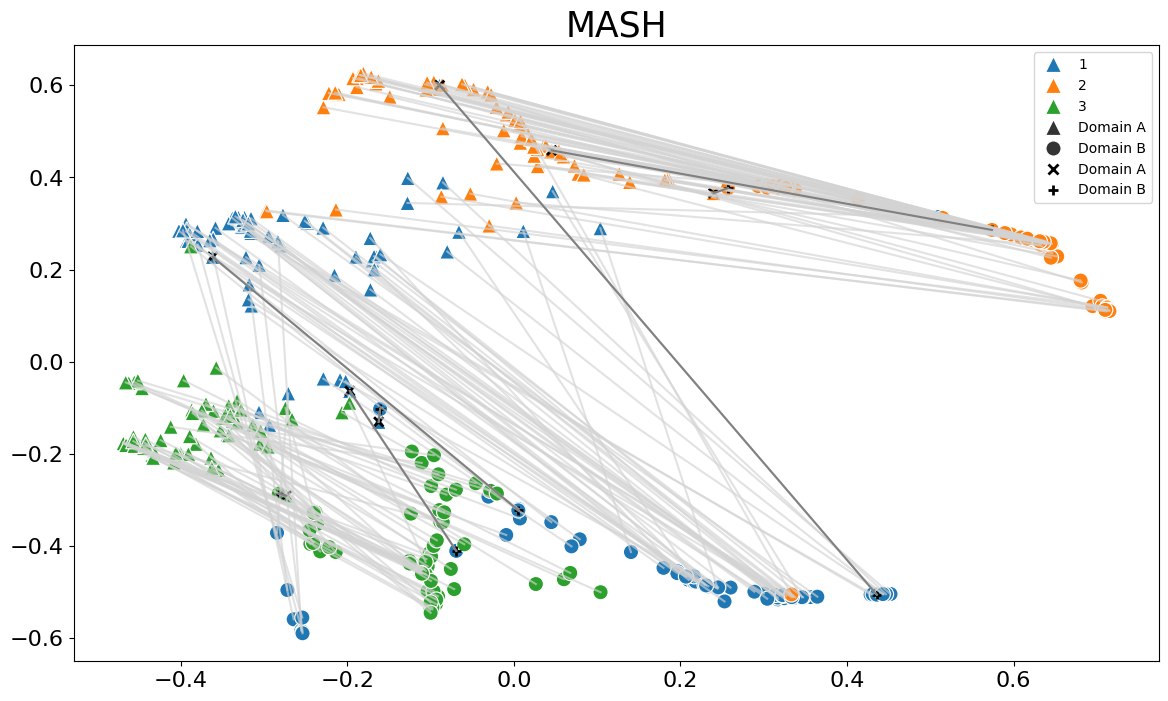

In [9]:
mash_class.plot_emb(labels = dc.labels_doubled)

# Using RF-Extend

### MASH

In [10]:
from Helpers.Pipeline_Helpers import *
from mashspud import MASH
import numpy as np
import pandas as pd
import Main.test_manifold_algorithms as tma
from mashspud import SPUD
from Helpers.rfgap import RFGAP
import matplotlib.pyplot as plt

In [11]:
dc = tma.test_manifold_algorithms(csv_file="iris.csv", split = "random", percent_of_anchors= [0.2], verbose = 4, random_state= 42)

MDS initialized with 2 components

 
 
---------------------------       Initalizing class with iris.csv data       ---------------------------

The knn values are: (2, 6, 10, 14, 18, 22, 26, 30, 34, 38)


In [12]:
mash_class = MASH(distance_measure_A = get_rf_proximites, distance_measure_B= get_rf_proximites, knn = 6, t = -1, verbose = 3, DTM = "log")
mash_class.fit(dataA = (dc.split_A, dc.labels), dataB = (dc.split_B, dc.labels), known_anchors = dc.anchors[:10])

Time Data Below


 Time it took to execute SGDM for domain A:  0.35548
 Time it took to execute the graph for domain A:  0.00226
 Time it took to execute SGDM for domain B:  0.35197
 Time it took to execute the graph for domain B:  0.00165
 Time it took to compute merge_graphs function:  0.09151
 Time it took to compute similarity_matrix function:  0.00028
Using optimal t value of 6
 Time it took to compute diffusion process:  0.09242
Fit process finished. We recommend calling optimize_by_creating_connections.


In [13]:
mash_class.get_scores(labels = dc.labels_doubled)

Time it took to calculate the embedding: 0.53545
RF-GAP score is accuracy
Calculating the classification Score.


(0.3601333333333333, 0.8466666666666667, 0.94)

In [14]:
from sklearn.model_selection import train_test_split

#Initialize SPUD Class
mash_class = MASH(distance_measure_A = rf_test_proximities, distance_measure_B= rf_test_proximities, knn = 6, t = -1, verbose = 3, DTM = "log")

X_A_train, X_A_test, y_A_train, y_A_test = train_test_split(dc.split_A, dc.labels, test_size=0.2, random_state=42)
X_B_train, X_B_test, y_B_train, y_B_test = train_test_split(dc.split_B, dc.labels, test_size=0.2, random_state=42)
labels_doubled = np.hstack((y_A_train, y_A_test, y_B_train, y_B_test))

#Fit SPUD
mash_class.fit(dataA = (X_A_train, X_A_test, y_A_train), dataB = (X_B_train, X_B_test, y_B_train), known_anchors = dc.anchors[:10])

Time Data Below
 Time it took to execute SGDM for domain A:  0.36374
 Time it took to execute the graph for domain A:  0.00238
 Time it took to execute SGDM for domain B:  0.35328
 Time it took to execute the graph for domain B:  0.00188
 Time it took to compute merge_graphs function:  0.09185
 Time it took to compute similarity_matrix function:  0.00059
Using optimal t value of 6
 Time it took to compute diffusion process:  0.13778
Fit process finished. We recommend calling optimize_by_creating_connections.


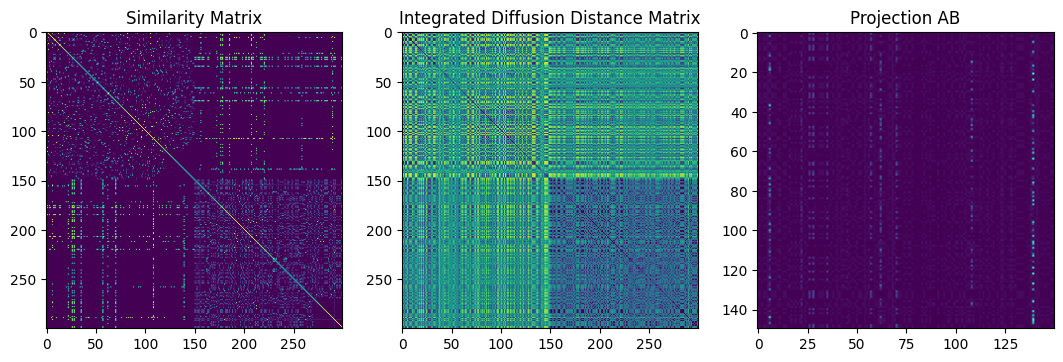

In [15]:
mash_class.plot_heat_maps()

Time it took to calculate the embedding: 0.55233
RF-GAP score is accuracy
Calculating the classification Score.
Cross Embedding score: 1.0
Fraction of Samples Closest to thier Match: 0.29448888888888886
RF score trained on full Embedding: 1.0


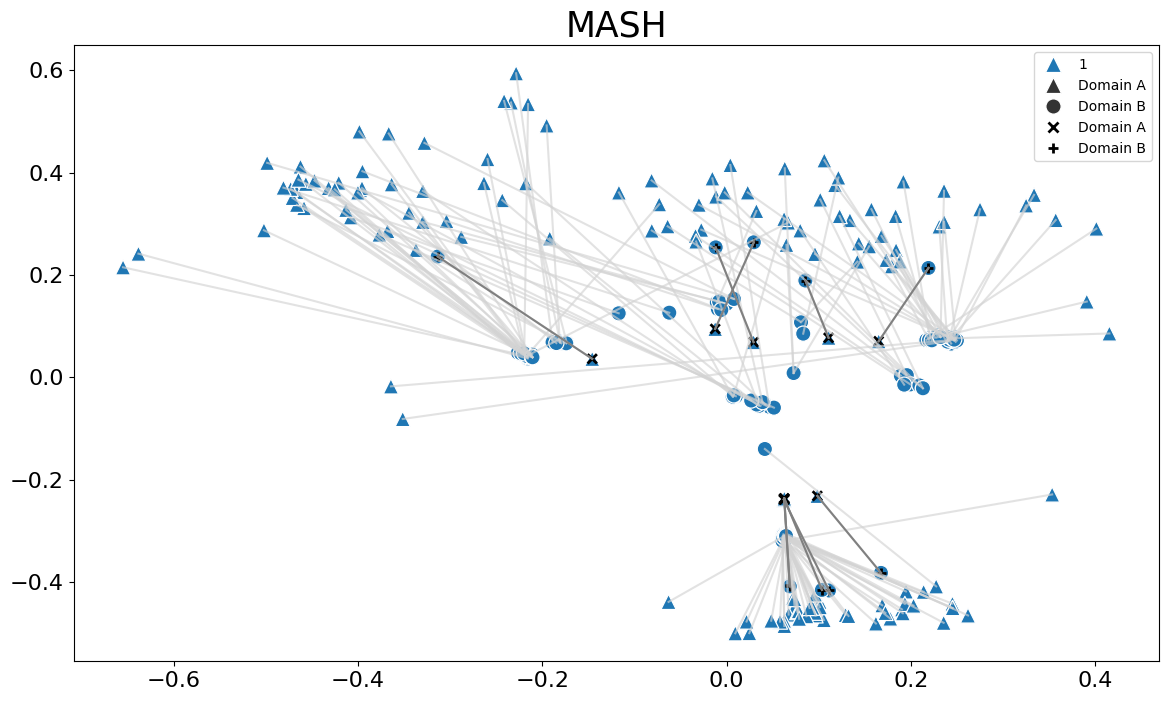

In [16]:
mash_class.plot_emb(labels=np.ones_like(dc.labels_doubled))

RF-GAP score is accuracy
Calculating the classification Score.
Cross Embedding score: 0.7966666666666666
Fraction of Samples Closest to thier Match: 0.29448888888888886
RF score trained on full Embedding: 0.84


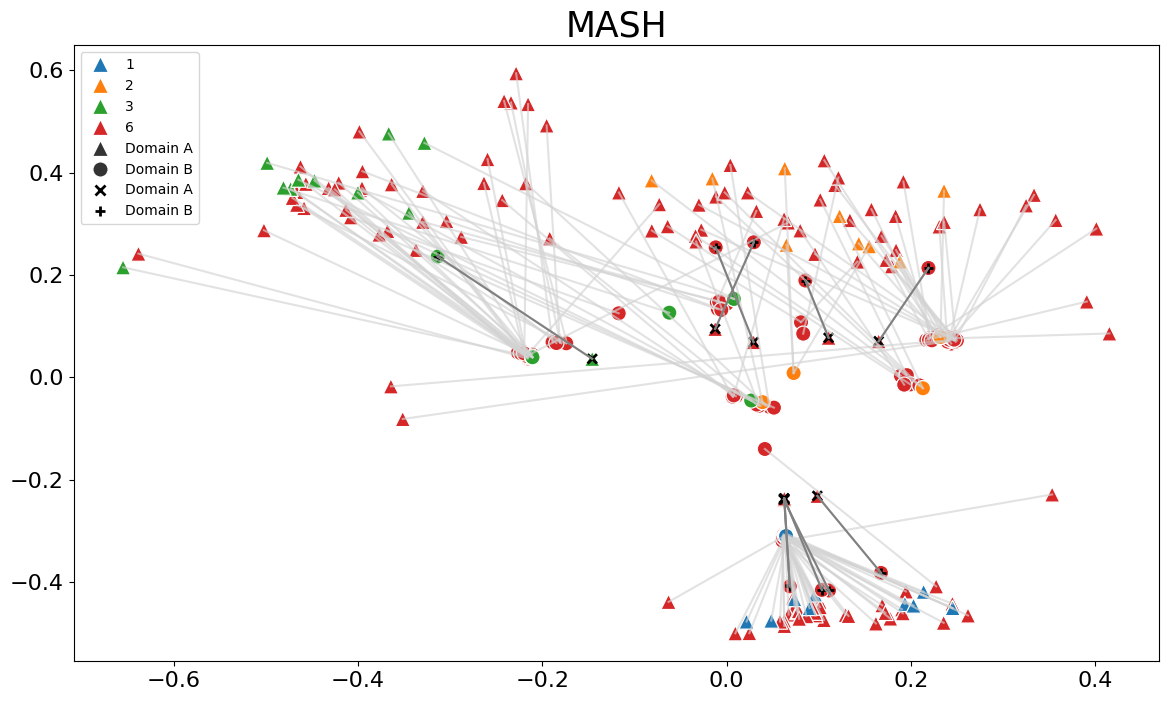

In [17]:
labels_greyed = np.hstack((np.ones_like(y_A_train)+5, y_A_test, np.ones_like(y_B_train)+5, y_B_test))
mash_class.plot_emb(labels = labels_greyed)

### Spud

In [18]:
from sklearn.model_selection import train_test_split

#Initialize SPUD Class
spud_class = SPUD(distance_measure_A = rf_test_proximities, distance_measure_B= rf_test_proximities, knn = 3, verbose = 4)

X_A_train, X_A_test, y_A_train, y_A_test = train_test_split(dc.split_A, dc.labels, test_size=0.2, random_state=42)
X_B_train, X_B_test, y_B_train, y_B_test = train_test_split(dc.split_B, dc.labels, test_size=0.2, random_state=42)
labels_doubled = np.hstack((y_A_train, y_A_test, y_B_train, y_B_test))

#Fit SPUD
spud_class.fit(dataA = (X_A_train, X_A_test, y_A_train), dataB = (X_B_train, X_B_test, y_B_train), known_anchors = dc.anchors[:10])

Time it took to compute SGDM:  0.71
Time it took to execute graphtools.Graph functions:  0.16
Time it took to execute merge_graphs function:  0.0
Time it took to execute get_block function:  0.02
<><><><><><><><><><><><><>  Processed Finished  <><><><><><><><><><><><><>


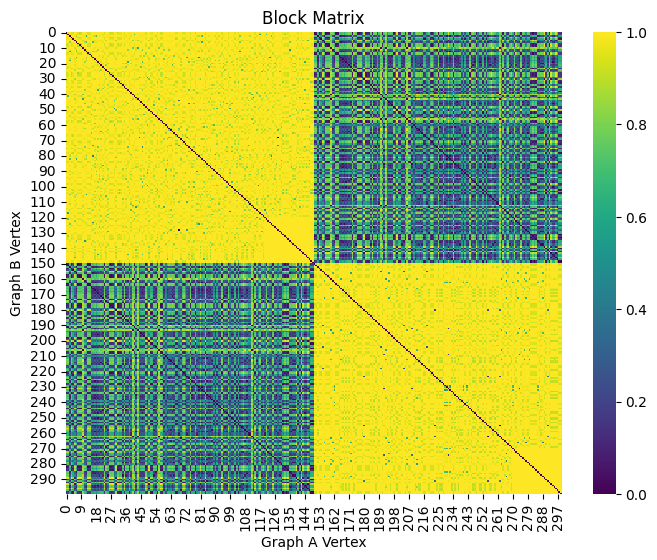

In [19]:
spud_class.plot_heat_map()

Time it took to calculate the embedding: 1.07
RF-GAP score is accuracy
Calculating the classification Score.
RF score on full embedding: 0.95
Cross Embedding score: 0.9533333333333334
Fraction of Samples Closest to thier Match: 0.0006666666666666668


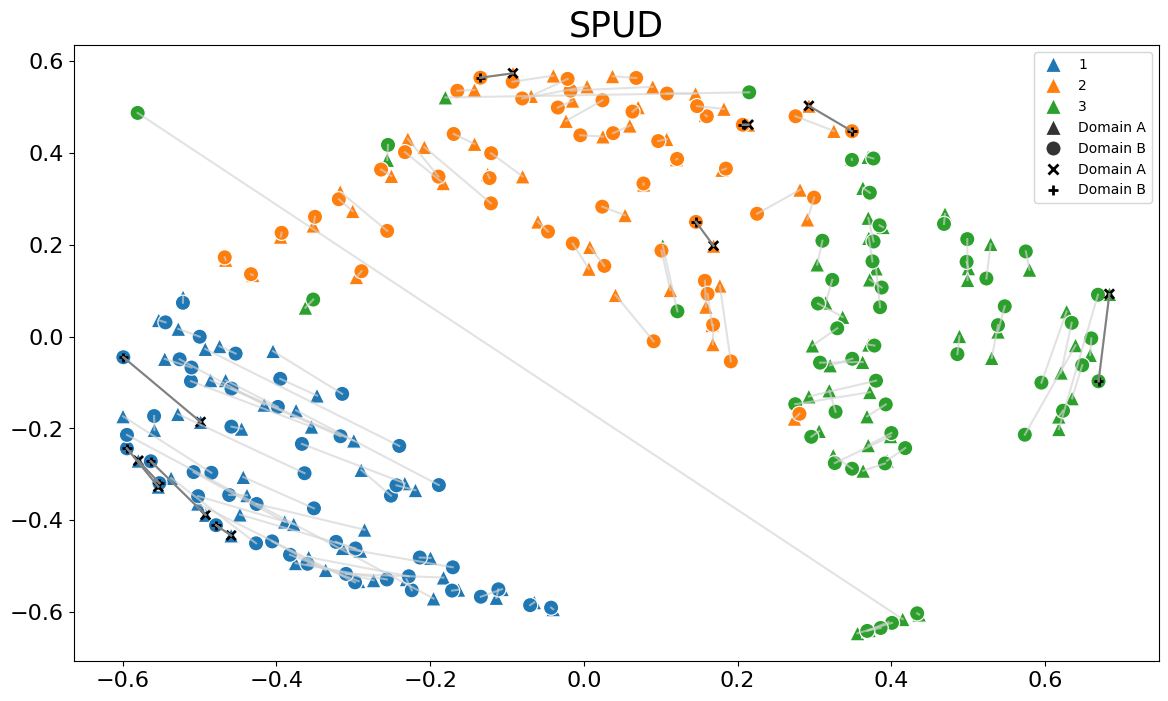

Time it took complete the plots: 0.61


In [20]:
spud_class.plot_emb(labels = labels_doubled)

RF-GAP score is accuracy


Calculating the classification Score.
RF score on full embedding: 0.76
Cross Embedding score: 0.7833333333333334
Fraction of Samples Closest to thier Match: 0.0006666666666666668


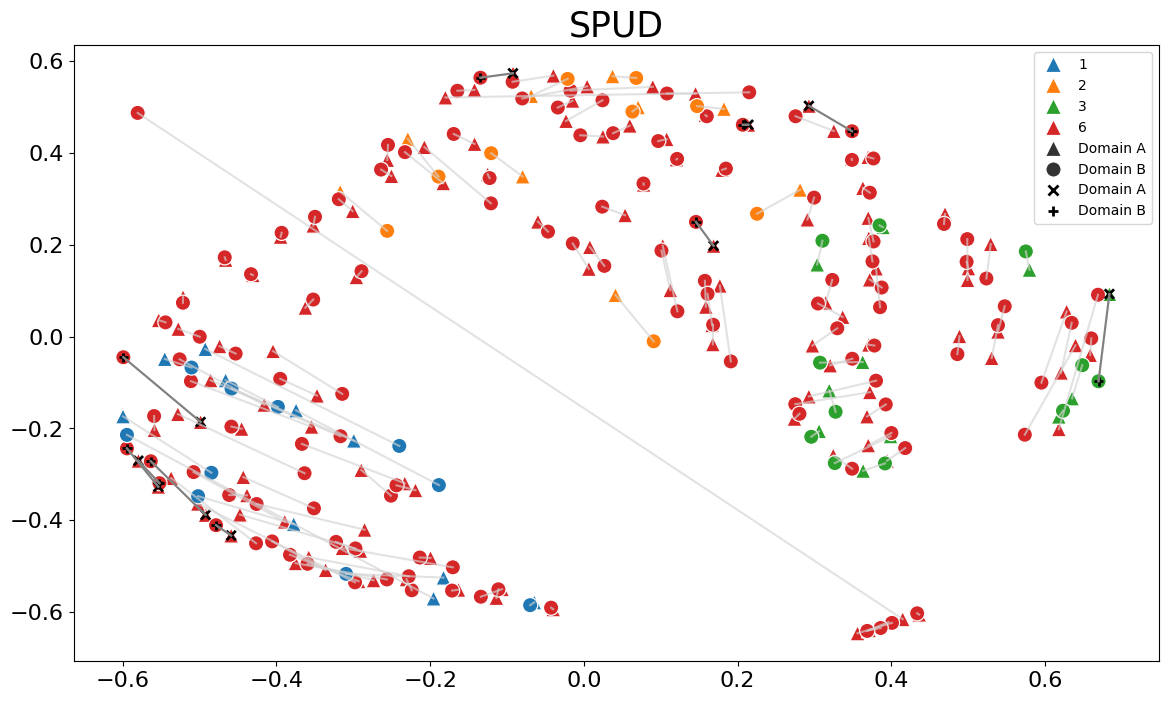

Time it took complete the plots: 0.61


In [21]:
labels_greyed = np.hstack((np.ones_like(y_A_train)+5, y_A_test, np.ones_like(y_B_train)+5, y_B_test))
spud_class.plot_emb(labels = labels_greyed)